## Plot multiple 

Artur Kaczmarczyk  | akaczmarczyk88@gmail.com   

Single Molecule Imaging Group | D. Rueda lab | Imperial College London | MRC LMS

version: December 2020

The script below loads all .h5 files from a folder that contain FD data and generate individual Force-Distance curves. 
Subsequently, every dataset is fitted with Worm-Like-Chain Model with predefined parameters.

Still to do:
- remove the non-extendableWLC part from this code
- histogram of the fitted values



In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from lumicks import pylake
import os
import sys

from tkinter import filedialog        # for opening dialog window
from tkinter import *


/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


## Import all FD curves located in a defined folder

In [4]:
# In the pop-up window, select the folder that contains .h5 files eith FD curves

root = Tk()
root.withdraw()
folder_selected = filedialog.askdirectory()
root.update()

# folder_selected =  r'/Users/Artur/OneDrive - Imperial College London/20200913'

filenames = os.listdir(folder_selected)          # all files in the chosen folder
Filenames = []                          

# selection of FD Curve.H5 files only

for filename in filenames:              
    if filename[-3:] == '.h5' and 'FD Curve' in filename:
        
        Filenames.append(filename)
        print(filename)
        
print(type(Filenames))

os.chdir(folder_selected)
os.getcwd()

20210130-190027 15kb_HJ_1_7umBead_60Hz_5nM_HO FD Curve 26.h5
<class 'list'>


'/Users/Artur/OneDrive - Imperial College London/C-TRAP data 2021/2021_01_30/FD 26'

## Load WLC functions

In [5]:
### Non-extendable WLC

    ## This function returns the forces computed from a 7-parameter WLC model 
    ## [Bouchiat et al. Biophys J 76:409 (1999)]

def wlc_7param(ext, Lp, Lc):
 
    # Lp = persistence length  (in micro-m)
    # Lc = contour length      (in micro-m)
    # T  = absolute temperature (in Kelvin)
    # k_B T in units of pN micro-m
    
    #Lc = 16.49
    T = 297
    Fwlc = []
    kT = 1.3806503 * 10**(-23) *T/(10**(-18)) 
    z_L = ext/Lc

    # parameters from the paper
    my_list = [1, -0.5164228, -2.737418, 16.07497, -38.87607,  39.49944, -14.17718]   

    a = np.asarray(my_list)
    Fwlc = 1/(4*(1 - z_L)**2)  - 1/4
    
    for i in range(0,len(a)):
        Fwlc = Fwlc + a[i] * z_L**[i]


    return Fwlc * kT/Lp;



### Extendable WLC

    ## WLC model that takes stretching modulus into account


def eWLC(force, Lp, L0, S):
    F = force
    kB = 1.38e-2
    T = 297
    #S = 1800    #stretching modulus (pN)
    C = kB * T / (Lp*1000)
    
    
    d = L0 - ((L0/2)*np.sqrt(C/F)) + (F*L0/S)
    
    return(d)



def fjc(f, Pars): 
    #"""calculates a Freely Jointed Chain with a kungslength of 
    #b = 3 KbT / k*L
    #where L is the length of the fiber in nm, and k the stiffness in nm pN per nucleosome""" 
    k_Cutof = 0.2   
    if Pars['k_pN_nm'] < k_Cutof:
        Pars['k_pN_nm'] = k_Cutof
        print('>>Warning, Low stiffness, FJC breaks with low stiffness, k=', k_Cutof, 
              ' used instead. If k<', k_Cutof, ' is needed, use Hookian spring model instead')
    b = 3 * Pars['kBT_pN_nm'] / (Pars['k_pN_nm']*Pars['ZFiber_nm'])
    x = f * b / Pars['kBT_pN_nm']
    z = (np.exp(x) + 1 / np.exp(x)) / (np.exp(x) - 1 / np.exp(x)) - 1 / x
    #coth(x)= (exp(x) + exp(-x)) / (exp(x) - exp(x)) --> see Wikipedia
    #z *= Pars['L_bp']*Pars['DNAds_nm']   #work /dG term not used atm
    #z_df = (Pars['kBT_pN_nm'] / b) * (np.log(np.sinh(x)) - np.log(x))  #*L_nm #  + constant --> integrate over f (finish it
    #w = f * z - z_df
    return z * (Pars['N_tot']-Pars['N4'])


In [6]:
# LEAST SQUARE METHOD is used to fit the persistence length and the contour length beased on the non-eWLC

# Predefine the expected range (in micrometers)
PL_min = 0.025 
PL_max = 0.075
CL_min = 5.0
CL_max = 6.1
S_min = 900 # pN
S_max = 1800 #pN


# Choose the part of the data to be fitted   

force_treshold = 42     # pN  
force_treshold_min = 32 # pN

Force-distance curve I.D. = ['26']


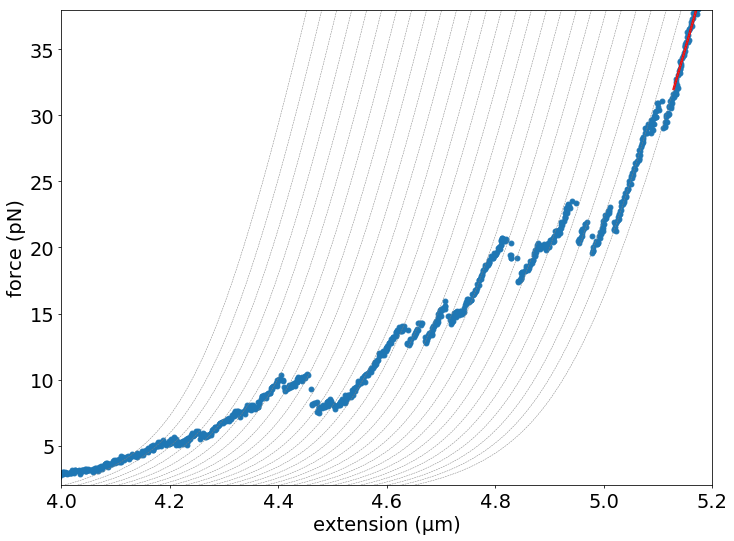

In [10]:
for k in range(len(Filenames)):
    
    
    file = pylake.File(Filenames[k])
    print("Force-distance curve I.D. = " + str(list(file.fdcurves)))
    curve_number = (list(file.fdcurves))   
    
    
    index = 0 # keep ZERO when there is only one FD curve within the .h5 file, increments +1 would correspond with the list of indexes for remaining FD curve generated in the same .h5 file
    
    fd = file.fdcurves[(curve_number[index])]
    force = fd.f
    distance = fd.d

    
    # Stretching curve
    plt.figure(figsize=(12, 9), dpi=70)
    if np.sum(np.diff(distance.data)) > 0:
        
        plt.scatter(distance.data,force.data, s = 25)

        indices_bottom = [i for i,v in enumerate(force.data > force_treshold_min ) if v]
        indices_top = [i for i,v in enumerate(force.data > force_treshold) if v]
        b1 = indices_bottom[0]
        b2 = indices_top[0]

        popt2, pcov2 = curve_fit(eWLC, force.data[b1:b2], distance.data[b1:b2], bounds=([PL_min,CL_min,S_min],[PL_max,CL_max,S_max]))
        perr = np.sqrt(np.diag(pcov2)) # standard deviation errors of the parameters
        
        np.savetxt('Fd_'+ (curve_number[index]) + '.csv' , np.c_[distance.data, force.data], delimiter=",")
    
        plt.plot(eWLC(np.linspace(force_treshold_min,force_treshold,1000), *popt2),np.linspace(force_treshold_min,force_treshold,1000),  'r-',linewidth=2.5, label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt2))

        
        ## Plot intermediate states
        step = 0.027
        N = 27  # how many steps 
        intermediate_fit = np.linspace(0.05,force_treshold,1000) 
        
        intermediate_fit_col = intermediate_fit.reshape(-1, 1).copy()

        for i in range(0,N): 

            fitfit = eWLC(np.linspace(0.05,force_treshold,1000), *popt2)
            fitfit_col = fitfit.reshape(-1,1).copy()
            intermediate_fit_col = np.append(intermediate_fit_col,fitfit_col,axis=1)
            
            plt.plot(fitfit, np.linspace(0.05,force_treshold,1000),linestyle='dashed',color='grey',linewidth=0.5, label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt2))

            popt2[1]=popt2[1]-step
            
            
        np.savetxt('Intermediate2_'+ (curve_number[index]) + '.csv' , np.c_[intermediate_fit_col], delimiter=",")
        
        
    # Refolding curve
    if np.sum(np.diff(distance.data)) < 0:
        
        plt.scatter(distance.data, force.data, s = 25, color = 'silver')
    
        indices_bottom = [i for i,v in enumerate(force.data > force_treshold_min ) if v]
        indices_top = [i for i,v in enumerate(force.data < force_treshold) if v]
        b1 = indices_bottom[-1]
        b2 = indices_top[0]  
        
        popt, pcov2 = curve_fit(eWLC,  force.data[b2:b1], distance.data[b2:b1], bounds=([PL_min,CL_min,S_min],[PL_max,CL_max,S_max]))
        perr = np.sqrt(np.diag(pcov2)) # standard deviation errors of the parameters
        
        np.savetxt('Fd_'+ (curve_number[index]) + '.csv' , np.c_[distance.data, force.data], delimiter=",")

        plt.plot(eWLC(np.linspace(force_treshold_min,force_treshold,1000), *popt), np.linspace(force_treshold_min,force_treshold,1000),  'r-',linewidth=2.5, label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt))
        
        ## Plot intermediate states
        step = 0.020
        N = 48  # how many steps 
        intermediate_fit = np.linspace(0.05,force_treshold,1000) 
        
        intermediate_fit_col = intermediate_fit.reshape(-1, 1).copy()

        for i in range(0,N): 

            fitfit = eWLC(np.linspace(0.05,force_treshold,1000), *popt2)
            fitfit_col = fitfit.reshape(-1,1).copy()
            intermediate_fit_col = np.append(intermediate_fit_col,fitfit_col,axis=1)
            
            plt.plot(fitfit, np.linspace(0.05,force_treshold,1000),linestyle='dashed',color='grey',linewidth=0.5, label='fit: a=%5.3f, b=%5.3f, c =%5.0f' % tuple(popt2))

            popt2[1]=popt2[1]-step
            
            
        np.savetxt('Intermediate2_'+ (curve_number[index]) + '.csv' , np.c_[intermediate_fit_col], delimiter=",")
    plt.xlim(2.4, 5.3)
    plt.ylim(-0.1, 50)
    plt.xlabel('extension (\u03BCm)')    
    plt.ylabel('force (pN)')   
    plt.savefig('fit_FD_' + (curve_number[index]) + '.png', dpi=300, bbox_inches='tight')
    plt.rc('font', size=11)

    #leg = plt.legend(('fit eWLC, PL = '+ str(round(popt2[0]*1000))+ ' $ \pm $ '+ str(round(perr[0]*1000)) + ' nm, CL = '+str(round(popt2[1],2))+ ' $ \pm $ '+ str(round(perr[1],2)) +' \u03BCm , S = ' + str(round(popt2[2])) + ' $ \pm $ '+ str(round(perr[2],2)) ,'data'+str((curve_number[index]))))
    #leg.get_frame().set_linewidth(0.0)

    #np.savetxt('Fd_'+ (curve_number[index]) + '.csv' , np.c_[distance.data[np.argmax(force.data):len(force.data)], force.data[np.argmax(force.data):len(force.data)]], delimiter=",")
    #np.savetxt('Fd_fit'+ (curve_number[index]) + '.csv' , np.c_[d_wave, f_wave], delimiter=",")

    plt.rc('font', size=20)


    #plt.plot(d_wave2, f_wave,'--',color = 'silver')
    #plt.xlabel('extension (\u03BCm)')    
    #plt.ylabel('force (pN)')   
    plt.xlim(4, 5.2)
    plt.ylim(2, 38)
    #plt.savefig('zoom_FD_' + (curve_number[index]) + '.png', dpi=300, bbox_inches='tight')


    plt.savefig('ZOOM_fit_FD_' + (curve_number[index]) + '.png', dpi=300, bbox_inches='tight')



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


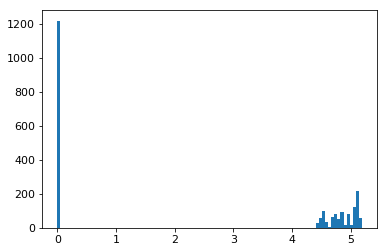

Text(65.875,0.5,'counts')

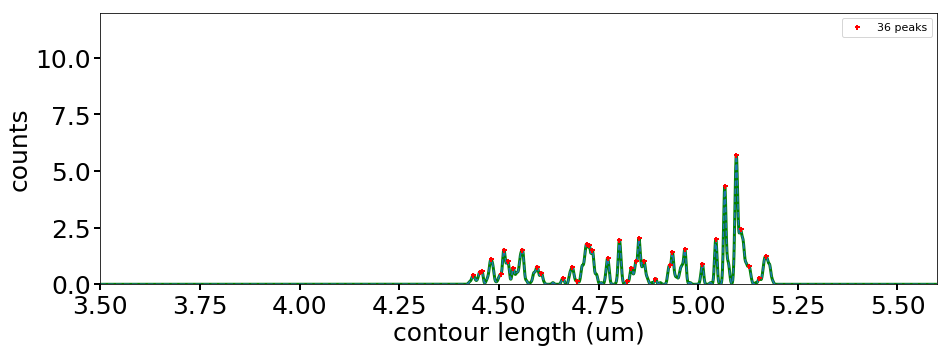

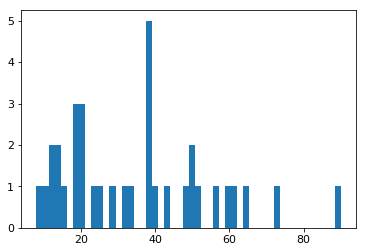

In [15]:

from scipy.stats import gaussian_kde


import peakutils
from peakutils.plot import plot as pplot



## contour length quantification within ribs
def CLT_eWLC(distance, force, threshold=5, Lp=50):
   d = distance
   F = force
   kB = 1.38e-2
   T = 297
   K = 1000
   C = kB * T / Lp

   F_t = F

   #Apply threshold setting vales < threshold to np.nan
   F_t_indicies = (F < threshold) #Ignores points below this threshold
   F_t[F_t_indicies] = 0

   F_t_indicies = (F > 120) #Ignores points above this threshold
   F_t[F_t_indicies] = 0

   FE_CLT = d/(1-0.5 * np.sqrt(C/F_t) + F/K)
   return(FE_CLT)





#Analyze stretching curve
clt_up = CLT_eWLC(distance.data[0:np.argmax(force.data)], force.data[0:np.argmax(force.data)])

#fd = fd_down
#clt_down = CLT_eWLC(fd.distance1.data, fd.downsampled_force2x.data)

plt.hist(clt_up, bins = 100)
#plt.hist(clt_down, bins = 2000)
#plt.xlim((5,16))
#plt.ylim((0,1000))
plt.show()


# "Walking" Gaussian fit
gkde=gaussian_kde(clt_up, bw_method=0.001)
ind = np.linspace(0,6,10000)
kdepdf = gkde.evaluate(ind)
indexes = peakutils.indexes(kdepdf, thres=0.001, min_dist=0.01)   #returns the x-axis

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ind, kdepdf,'g', linewidth=3.0)
ax.tick_params(direction='out', length=6, width=2, labelsize= 25,
               grid_color='r', grid_alpha=0.5)
ax.set_xlabel("contour length (um)", fontsize=25)
ax.set_ylabel("counts", fontsize=25)
pplot(ind, kdepdf, indexes)
plt.xlim((3.5,5.6))

plt.ylim((0,12))

plt.savefig('Steps_' + (curve_number[index]) + '.png', dpi=300, bbox_inches='tight')
np.savetxt('PeaksData_' + (curve_number[index]) + '.csv', np.c_[ind,kdepdf], delimiter=",")
np.savetxt('PeaksIndexes_' + (curve_number[index]) + '.csv', np.c_[indexes], delimiter=" ")

#plt.plot(ind, kdepdf, label='kde', color="g")

# Detect peak position
#indexes = peakutils.indexes(kdepdf, thres=0.01, min_dist=0.001)   #returns the x-axis
#print('Peaks: ' + str(indexes/1000))

fig2, ax2 = plt.subplots()
steps = np.diff(indexes)
np.savetxt('Steps_' + (curve_number[index]) + '.csv', np.c_[steps], delimiter=" ")
#print(steps)
#plt.hist(steps, bins = 100)
plt.hist(steps,bins=50)
#plt.xlim((0,300))
ax.tick_params(direction='out', length=6, width=2, labelsize= 25,
               grid_color='r', grid_alpha=0.5)
ax.set_xlabel("contour length (um)", fontsize=25)
ax.set_ylabel("counts", fontsize=25)



#fig2, ax2 = plt.subplots(figsize=(30, 10))
#ax2.plot(kdepdf,'g', linewidth=3.0)
#fig3, ax3 = plt.subplots(figsize=(30, 10))
#ax3.plot(kdepdf,'g', linewidth=3.0)
#plt.ylim((0,0.4))
#plt.xlim((3000,8000))